<h3>Codice per la simulazione del segnale a "singolo" fotone</h3>
<ul>
    <li>Verificare l'ordine di grandezza tra noise e signal. Se sono dello stesso ordine, nel momento in cui si esegue la derivata prima del segnale, il noise manda a benedire tutto il segnale e non si può operare sulla derivata. Nell'articolo <i>Development of Microwave Kinetic Inductance Detectors for IR Single-Photon Counting</i>, è stato filtrato il segnale, non bisogna tenere quello come riferimento. (Problematica chiesta per e-mail a Faverzani, si attendono articoli per un riferimento).</li>
    <li>Al momento si lavora sul segnale con poco noise (dev std = 0.5) per verificare che tutto il codice sul trigger funzioni.</li>
</ul>

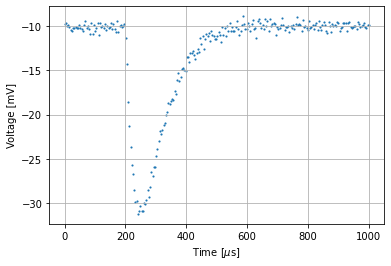

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def gen_signal(x=np.linspace(0,1000,2000), baseline=0, amplitude=140, rise_time=40, decay_time=60, pulse_start=200, noise_lev=0.5):
    signal = baseline+1*amplitude*(np.exp(-x/rise_time)-np.exp((-x/decay_time)))
    signal = np.interp(x, x+pulse_start, signal)
    noise = np.random.normal(scale=noise_lev, size=len(signal))

    return signal+noise

time = np.linspace(0,1000,250)
signal = gen_signal(baseline=-10, x=time)
#clean_signal = gen_signal(baseline=-10, x=time, noise_lev=0)

plt.scatter(time, signal, marker='.', s=5)
#plt.scatter(time, clean_signal, color="r", marker='.', s=2)
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Voltage [mV]')

plt.grid()
plt.show()

<h4>Derivative Trigger</h4>
<ul>
    <li>I valori per il begin e l'end sono scelti in maniera casuale, risulta comodo lavorare con qualche punto in più per avere un buon intervallo su cui applicare il <code>savgol_filter()</code>. Al momento questa scelta non sembra dare problemi.
    <li>Un primo problema che si verificava a seconda del segnale era la scelta della <code>window_length</code>. Il filtro vuole che sia dispari, usare la lunghezza tra begin ed end non è sempre comoda, un tentativo di risoluzione è stato valutarne la parità prima e sistemarla prima di applicare il filtro. Sembra funzionare, si può far meglio?</li>
    <li>La scelta del polinomio varia a seconda della <code>window_length</code>, generalmente si lavora con ordini compresi tra l'8 e il 12 ordine, una problematica che emerge raramente è avere <code>window_length=50</code>, per cui andremmo a fittare con un polinomio di 49esimo grado. Questo non è buono, al momento ho limitato superiormente l'ordine del polinomio, va capito se la <code>window_length</code> così grande si possa tenere oppure no.</li>
    <li>Nel plotting escludo i primi 2 e gli ultimi 2 punti, poiché spesso e volentieri sono tanto distanti rispetto agli altri e potrebbe compromettere la valutazione del punto di minimo. Non è una scelta ottimale, una possibile soluzione è quella di valutare una deviazione standard e fare un filtro prima su questi punti (array prodotto dal <code>savgol_filter()</code>), in maniera tale che il minimo che si scelga sia compatibile con il punto in cui inizia il segnale.</li>
</ul>
Risolti questi aspetti che conducono all'individuazione del punto del cambio di derivata, si può procedere a valutare una soglia sulla derivata seconda e di conseguenza acquisire il segnale.

In [206]:
def derivative_trigger(sample, n=2):
    first_derivative = np.diff(sample, n=1)
    n_points, i = 0, 0
    std = np.std(first_derivative[0:100])/2 
    index_min = first_derivative.argmin()
    tot = index_min
    
    while first_derivative[index_min] < -std:
        index_min -= 1
    tot = tot - index_min

    while(n_points < tot):
        n_points = n_points + 1 if (first_derivative[i] < - std) else 0
        i += 1
    
    start = i - tot
    end = first_derivative.argmin() + 7
    begin = start - 6 if start - 6 > 0 else 0 # Altrimenti è negativo e parte dalla coda
    # I valori 6 e 7 sono casuali, si tratta di prendere qualche punto prima e dopo da permettere un buon fit per il savgol

    # A volte ci sono problemi perché il savgol richiede una window_length dispari, ora non dovrebbero esserci problemi
    # Errore che esce: "window_length must be odd."
    window_length = len(sample[begin:end])-1 if len(sample[begin:end]) % 2 == 0 else len(sample[begin:end])

    # print(window_length)

    # Inutile scegliere il polinomio più adatto nel range 8-12, prendiamo il polinomio di grado massimo che accetta il savgol prendendo window_length-1
    poly_order = window_length-1 if window_length < 14 else 12
    derivative_func = savgol_filter(sample[begin:end], window_length, poly_order, n, delta=1)

    # Scartiamo i primi due punti e gli ultimi due perché vanno a influenzare la ricerca del minimo [1] 
    plt.scatter(time[begin+2:end-3], derivative_func[2:-3], color="g")
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Voltage [mV]')
    plt.grid()
    plt.show()
    
    return

Per la parametrizzazione del segnale data all'inizio, il punto di cambio derivata (valore minimo) si deve presentare nell'interno dei 200 microsec. 

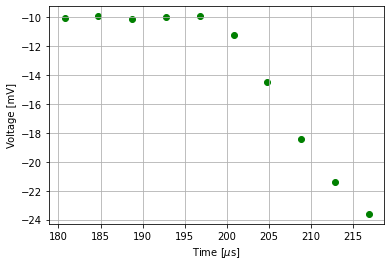

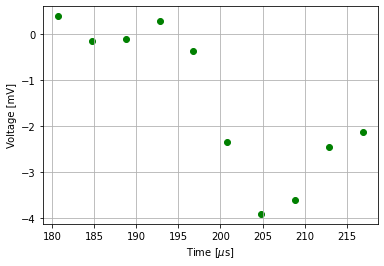

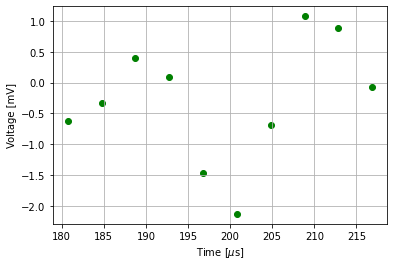

In [207]:
derivative_trigger(signal, n=0)
derivative_trigger(signal, n=1)
derivative_trigger(signal, n=2)